## Скачивание датасета

In [4]:
!wget -o retail https://archive.ics.uci.edu/static/public/352/online+retail.zip

In [5]:
!unzip online+retail.zip

Archive:  online+retail.zip
 extracting: Online Retail.xlsx      


## Сохранение в формате csv

In [6]:
import pandas as pd

In [14]:
EXCEL_PATH = "Online Retail.xlsx"
CSV_PATH = "retail.csv"

In [17]:
df = pd.read_excel(EXCEL_PATH)
df.to_csv(CSV_PATH, index=False)

In [18]:
del df

## Анализ данных на pyspark

### Открытие датасета

In [12]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b4c184fa75c7d04a6d608ba2f46473c4ef9de496e10a879198c6a9cd8b266394
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [13]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PySpark").master("local").getOrCreate()

In [19]:
from pyspark.sql.types import *

schema  = StructType([
  StructField("InvoiceNo", StringType(), True),
  StructField("StockCode", StringType(), True),
  StructField("Description", StringType(), True),
  StructField("Quantity", IntegerType(), True),
  StructField("InvoiceDate", DateType(), True),
  StructField("UnitPrice", FloatType(), True),
  StructField("CustomerID", StringType(), True),
  StructField("Country", StringType(), True),
])

In [20]:
sdf = spark.read.format("csv").option("header",True).schema(schema).load(CSV_PATH)

In [21]:
sdf.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- UnitPrice: float (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



**InvoiceNo** is a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation

**StockCode** is a 5-digit integral number uniquely assigned to each distinct product

**CustomerID** is a 5-digit integral number uniquely assigned to each customer

### Изучение датасета

In [30]:
import pyspark.sql.functions as F

In [45]:
country_df = sdf.select(sdf.Country).distinct().toPandas()
country_df.Country.values

array(['Sweden', 'Singapore', 'Germany', 'RSA', 'France', 'Greece',
       'European Community', 'Belgium', 'Finland', 'Malta', 'Unspecified',
       'Italy', 'EIRE', 'Lithuania', 'Norway', 'Spain', 'Denmark',
       'Hong Kong', 'Iceland', 'Israel', 'Channel Islands', 'USA',
       'Cyprus', 'Saudi Arabia', 'Switzerland', 'United Arab Emirates',
       'Canada', 'Czech Republic', 'Brazil', 'Lebanon', 'Japan', 'Poland',
       'Portugal', 'Australia', 'Austria', 'Bahrain', 'United Kingdom',
       'Netherlands'], dtype=object)

In [24]:
transaction_count = sdf.select(sdf.InvoiceNo).distinct().count()
print("Количество уникальных транзакций: ", transaction_count)

Количество уникальных транзакций:  25900


In [39]:
customer_transaction_amount = (
    sdf.select(sdf.InvoiceNo, sdf.CustomerID, sdf.Quantity, sdf.UnitPrice)
    .filter(sdf.InvoiceNo.startswith("C") == False)
    .withColumn("ProductAmount", sdf.Quantity * sdf.UnitPrice)
    .groupBy(sdf.CustomerID, sdf.InvoiceNo)
    .agg(
        F.sum("ProductAmount").alias("SumProductAmount"),
    )
)

In [46]:
customer_transaction_amount.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- SumProductAmount: double (nullable = true)



In [48]:
customer_country = sdf.select(sdf.CustomerID, sdf.Country).distinct()

In [50]:
customer_country.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



In [64]:
country_all_amount = (
    customer_transaction_amount
    .join(
        customer_country,
        on="CustomerID",
        how='inner'
    )
    .groupBy("Country")
    .agg(
        F.sum("SumProductAmount").alias("Amount"),
    )
    .withColumn("Amount", F.col("Amount").cast(IntegerType()))
    .sort(F.desc("Amount"))
)

In [65]:
country_all_amount.show()

+---------------+-------+
|        Country| Amount|
+---------------+-------+
| United Kingdom|7308391|
|    Netherlands| 285446|
|           EIRE| 265545|
|        Germany| 228867|
|         France| 209024|
|      Australia| 139911|
|          Spain|  66488|
|    Switzerland|  57222|
|        Belgium|  48038|
|         Sweden|  38378|
|          Japan|  37416|
|         Norway|  36165|
|       Portugal|  33439|
|        Finland|  22546|
|      Singapore|  21279|
|Channel Islands|  20450|
|        Denmark|  19774|
|          Italy|  17483|
|        Austria|  16779|
|         Cyprus|  16606|
+---------------+-------+
only showing top 20 rows



In [75]:
amount_by_date = (
    sdf.select(sdf.InvoiceDate, sdf.Country, sdf.Quantity, sdf.UnitPrice)
    .withColumn("ProductAmount", sdf.Quantity * sdf.UnitPrice)
    .withColumn("Date", F.col("InvoiceDate").cast('date'))
    .groupBy("Date", "Country")
    .agg(
        F.sum("ProductAmount").alias("Amount")
    )
    .sort(F.asc("Country"), F.asc("Date"))

).toPandas()

<Axes: xlabel='Date', ylabel='Amount'>

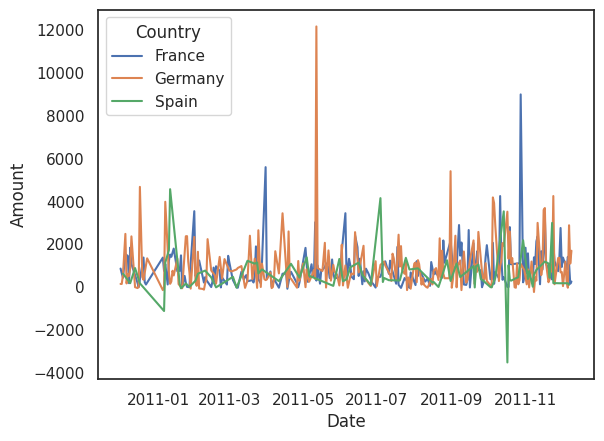

In [82]:
import seaborn as sns

sns.set_style("white")
filtered_amount_by_date = amount_by_date.query("Country in ('Spain', 'Germany', 'France')")
sns.lineplot(data=filtered_amount_by_date, x="Date", y="Amount", hue="Country")

In [ ]:
|